# Capstone 2: Prediction of Mortgage Loan Type 

### Background/Motivation:
There are many features that go into deciding whether someone will be approved or denied a home loan. There are different programs made available by different lenders, and a consumer may qualify for one or more programs based on their financial profile. While we cannot assume that historical data supports which program is the best option for a client, we can use it to predict which program will likely end up being the program they choose. For a system that shows a user all the loan options they may qualify for, it could cut down on time spent sifting through loan programs if we could predict with high probability which loan program is the most likely option, and present that to the consumer while sifting through the rest of the options to present. This project aims at predicting the loan type between Conventional and FHA mortgage, given some initial information about the consumer and intent behind the mortgage application.

In [81]:
import pandas as pd
import numpy as np
from numpy.random import seed
seed(123)
import matplotlib.pyplot as plt
from collections import OrderedDict
%matplotlib inline
from datetime import datetime
import seaborn as sns
import geopandas as gpd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
import time
#from keras import models, layers, optimizers, regularizers
#from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats

pd.set_option('display.max_columns', None)


In [82]:
df = pd.read_csv('year_2018_state_CA.csv')
#original_length = len(df)
#print(f"The dataset contains {original_length} loan files")

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (4,5,22,23,24,26,27,28,29,30,31,32,33,38,43,44,46,78,80) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Let's explore the columns of the dataset:

In [83]:
df.columns

Index(['activity_year', 'lei', 'derived_msa-md', 'state_code', 'county_code',
       'census_tract', 'conforming_loan_limit', 'derived_loan_product_type',
       'derived_dwelling_category', 'derived_ethnicity', 'derived_race',
       'derived_sex', 'action_taken', 'purchaser_type', 'preapproval',
       'loan_type', 'loan_purpose', 'lien_status', 'reverse_mortgage',
       'open-end_line_of_credit', 'business_or_commercial_purpose',
       'loan_amount', 'loan_to_value_ratio', 'interest_rate', 'rate_spread',
       'hoepa_status', 'total_loan_costs', 'total_points_and_fees',
       'origination_charges', 'discount_points', 'lender_credits', 'loan_term',
       'prepayment_penalty_term', 'intro_rate_period', 'negative_amortization',
       'interest_only_payment', 'balloon_payment',
       'other_nonamortizing_features', 'property_value', 'construction_method',
       'occupancy_type', 'manufactured_home_secured_property_type',
       'manufactured_home_land_property_interest', 'total_

There is a handy glossary on the HMDA site which I used to understand what these labels meant, and what the categorical codes stood for:
https://ffiec.cfpb.gov/documentation/2019/lar-data-fields/

### Let's explore a sampling of the dataset to see what these entries look like:

In [84]:
df.head()

,activity_year,lei,derived_msa-md,state_code,county_code,census_tract,conforming_loan_limit,derived_loan_product_type,derived_dwelling_category,derived_ethnicity,derived_race,derived_sex,action_taken,purchaser_type,preapproval,loan_type,loan_purpose,lien_status,reverse_mortgage,open-end_line_of_credit,business_or_commercial_purpose,loan_amount,loan_to_value_ratio,interest_rate,rate_spread,hoepa_status,total_loan_costs,total_points_and_fees,origination_charges,discount_points,lender_credits,loan_term,prepayment_penalty_term,intro_rate_period,negative_amortization,interest_only_payment,balloon_payment,other_nonamortizing_features,property_value,construction_method,occupancy_type,manufactured_home_secured_property_type,manufactured_home_land_property_interest,total_units,multifamily_affordable_units,income,debt_to_income_ratio,applicant_credit_score_type,co-applicant_credit_score_type,applicant_ethnicity-1,applicant_ethnicity-2,applicant_ethnicity-3,applicant_ethnicity-4,applicant_ethnicity-5,co-applicant_ethnicity-1,co-applicant_ethnicity-2,co-applicant_ethnicity-3,co-applicant_ethnicity-4,co-applicant_ethnicity-5,applicant_ethnicity_observed,co-applicant_ethnicity_observed,applicant_race-1,applicant_race-2,applicant_race-3,applicant_race-4,applicant_race-5,co-applicant_race-1,co-applicant_race-2,co-applicant_race-3,co-applicant_race-4,co-applicant_race-5,applicant_race_observed,co-applicant_race_observed,applicant_sex,co-applicant_sex,applicant_sex_observed,co-applicant_sex_observed,applicant_age,co-applicant_age,applicant_age_above_62,co-applicant_age_above_62,submission_of_application,initially_payable_to_institution,aus-1,aus-2,aus-3,aus-4,aus-5,denial_reason-1,denial_reason-2,denial_reason-3,denial_reason-4,tract_population,tract_minority_population_percent,ffiec_msa_md_median_family_income,tract_to_msa_income_percentage,tract_owner_occupied_units,tract_one_to_four_family_homes,tract_median_age_of_housing_units
0,2018,TR24TWEY5RVRQV65HD49,40140,CA,6071,6.071e+09,C,Conventional:Subordinate Lien,Single Family (1-4 Units):Site-Built,Hispanic or Latino,White,Male,3,0,2,1,2,2,2,1,2,25000.0,74.2,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,360,NaN,1,2,2,2,2,345000,1,1,3,5,1,NaN,71.0,44,7,10,11.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,2,4,5.0,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,2,4,1,5,2,4,25-34,9999,No,NaN,1,1,6,NaN,NaN,NaN,NaN,9,NaN,NaN,NaN,7800,70.21,65800,114,1433,2096,27
1,2018,TR24TWEY5RVRQV65HD49,44700,CA,6077,6.077e+09,C,Conventional:Subordinate Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,Black or African American,Female,3,0,2,1,2,2,2,1,2,35000.0,97.82,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,360,NaN,1,2,2,2,2,375000,1,1,3,5,1,NaN,102.0,>60%,7,10,2.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,2,4,3.0,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,2,4,2,5,2,4,35-44,9999,No,NaN,1,1,6,NaN,NaN,NaN,NaN,9,3.0,NaN,NaN,8228,80.40,63700,61,1249,2574,50
2,2018,TR24TWEY5RVRQV65HD49,31460,CA,6039,6.039e+09,C,Conventional:Subordinate Lien,Single Family (1-4 Units):Site-Built,Ethnicity Not Available,Race Not Available,Sex Not Available,3,0,2,1,4,2,2,1,2,35000.0,74.51,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,360,NaN,1,2,2,2,2,135000,1,1,3,5,1,NaN,124.0,<20%,7,7,3.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,2,2,6.0,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,2,2,3,1,2,2,35-44,25-34,No,No,1,1,6,NaN,NaN,NaN,NaN,9,3.0,NaN,NaN,5856,95.59,55200,53,358,1101,33
3,2018,TR24TWEY5RVRQV65HD49,40900,CA,6067,6.06701e+09,C,Conventional:Subordinate Lien,Single Family (1-4 Units):Site-Built,Ethnicity Not Available,Race Not Available,Sex Not Available,3,0,2,1,4,2,2,1,2,35000.0,79.34,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,360,NaN,1,2,2,2,2,325000,1,1,3,5,1,NaN,132.0,20%-<30%,7,10,3.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,2,4,6.0,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,2,4,3,5,2,4,25-34,9999,No,NaN,1,1,6,NaN,NaN,NaN,NaN,9,NaN,NaN,NaN,4905,65.91,80400,97,1042,1432,0
4,2018,TR24TWEY5RVRQV65HD49,40900,CA,6067,6.06701e+09,C,Conventional:Subordinate Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,Black or Afri

## Cleaning the dataset

There are quite a few columns and categories that I am not interested in to start out with. We have to keep in mind that this prediction would be used once a consumer provides minimal information, and are looking to purchase or refinance a residential property. The information we would have initially from the client includes:
- client address, 
- an approximate income, 
- total existing debt balances and payments, 
- occupancy (primary, second or investment), 
- loan purpose (purchase or refinance), 
- lien status (applying for a 1st or 2nd mortgage),

and there could be more we can extrapolate or information we can ask of the client if there end up being important features aside from these.

This loan type prediction would ultimately come before pricing out rate or term information, so that won't be an input to the model. Also, we don't initially know the race, ethnicity, age or sex information so that will be dropped for now. I will likely over-simplify the input values in the model at first to see how the simple model runs, and may add attributes back in if I see how to gather that information from a client initially.

From industry knowledge, I know the debt-to-income (DTI) ratio is going to be a good distinguishing factor, so I am going to drop the rows which do not have that information present. (I could fill this with an average value, but since we have over 1.6M entries in the dataset and only 12,723 have an "Exempt" value for DTI, I will just drop.)

We also don't want reverse or business/commercial loans included as this is strictly a model for residential amortizing mortgages.

In [85]:
len(df[df.debt_to_income_ratio=='Exempt'])

12723

In [86]:
df.drop(['action_taken','derived_loan_product_type','hoepa_status','purchaser_type','derived_msa-md','multifamily_affordable_units', 'intro_rate_period', 'prepayment_penalty_term','loan_term',
         'lender_credits', 'discount_points','total_points_and_fees','total_loan_costs','activity_year','lei', 'state_code', 'census_tract', 'county_code', 'other_nonamortizing_features',
         'derived_ethnicity', 'derived_race','derived_sex', 'applicant_ethnicity-1','applicant_ethnicity-2','applicant_ethnicity-3','applicant_ethnicity-4','applicant_ethnicity-5',
        'co-applicant_ethnicity-1','co-applicant_ethnicity-2','co-applicant_ethnicity-3','co-applicant_ethnicity-4','co-applicant_ethnicity-5',
        'applicant_ethnicity_observed', 'co-applicant_ethnicity_observed', 'applicant_race-1','applicant_race-2','applicant_race-3',
        'applicant_race-4','applicant_race-5','co-applicant_race-1','co-applicant_race-2','co-applicant_race-3','co-applicant_race-4',
        'co-applicant_race-5','applicant_race_observed','co-applicant_race_observed','applicant_sex', 'co-applicant_sex',
        'applicant_sex_observed', 'co-applicant_sex_observed', 'applicant_age', 'co-applicant_age','applicant_age_above_62',
        'co-applicant_age_above_62', 'submission_of_application', 'initially_payable_to_institution', 'aus-1','aus-2','aus-3',
        'aus-4','aus-5','denial_reason-1','denial_reason-2','denial_reason-3','denial_reason-4','ffiec_msa_md_median_family_income','loan_to_value_ratio', 'interest_rate', 'rate_spread', 
         'origination_charges', 'property_value'],axis=1,inplace=True)



In [87]:
df.manufactured_home_land_property_interest.value_counts()
#Here we see most values are "Not Applicable (5)" and "Exempt (1111)" so this doesn't really add much info
# ...We will get rid of the uncommon land property interests and then get rid of this attribute to clean up

5       1656002
1111      15092
3         15042
1         12886
4           371
2           346
Name: manufactured_home_land_property_interest, dtype: int64

In [88]:
#Getting rid of reverse_mortgage values of "Reverse Mortgage (1)" and "Exempt (1111)"
df.drop(df[df.reverse_mortgage==1].index, axis=0, inplace=True)
df.drop(df[df.reverse_mortgage==1111].index, axis=0, inplace=True)

#Getting rid of business_or_commercial_purpose values of "Primarily for a business or commercial purpose (1)" and "Exempt (1111)"
df.drop(df[df.business_or_commercial_purpose==1].index, axis=0, inplace=True)
df.drop(df[df.business_or_commercial_purpose==1111].index, axis=0, inplace=True)

#Here I drop property_interest of "Indirect Ownership (2)" and "Unpaid Leasehold (4)" to clean up attribute
df.drop(df[df.manufactured_home_land_property_interest==2].index, axis=0, inplace=True)
df.drop(df[df.manufactured_home_land_property_interest==4].index, axis=0, inplace=True)

df.drop(df[df.debt_to_income_ratio=='Exempt'].index, axis=0, inplace=True)

#Just keeping Conventional (1) and FHA (2) mortgages
df.drop(df[df.loan_type==3].index, axis=0, inplace=True)
df.drop(df[df.loan_type==4].index, axis=0, inplace=True)

In [89]:
df.drop(['reverse_mortgage','business_or_commercial_purpose','manufactured_home_land_property_interest',
         'open-end_line_of_credit','derived_dwelling_category','manufactured_home_secured_property_type',
       'manufactured_home_land_property_interest','co-applicant_credit_score_type','applicant_credit_score_type'],axis=1,inplace=True)

#### For the columns that are left, let's see which ones have null values:

In [90]:
for i in df.columns:
    print(df[i].isna().sum(), i, type(df[i][0]))

127 conforming_loan_limit <class 'str'>
0 preapproval <class 'numpy.int64'>
0 loan_type <class 'numpy.int64'>
0 loan_purpose <class 'numpy.int64'>
0 lien_status <class 'numpy.int64'>
0 loan_amount <class 'numpy.float64'>
0 negative_amortization <class 'numpy.int64'>
0 interest_only_payment <class 'numpy.int64'>
0 balloon_payment <class 'numpy.int64'>
0 construction_method <class 'numpy.int64'>
0 occupancy_type <class 'numpy.int64'>
0 total_units <class 'str'>
124537 income <class 'numpy.float64'>
470866 debt_to_income_ratio <class 'str'>
0 tract_population <class 'numpy.int64'>
0 tract_minority_population_percent <class 'numpy.float64'>
0 tract_to_msa_income_percentage <class 'numpy.int64'>
0 tract_owner_occupied_units <class 'numpy.int64'>
0 tract_one_to_four_family_homes <class 'numpy.int64'>
0 tract_median_age_of_housing_units <class 'numpy.int64'>


#### Missing DTI and Income

I was curious to see if the missing income values were also entries that had DTI missing since they are related attributes.

In [91]:
#creating lists of indices
income_na_index = df[df.income.isna()==True].index.tolist()
debt_to_income_ratio_na_index = df[df.debt_to_income_ratio.isna()==True].index.tolist()

# using all() to check subset of list  
flag = 0
if(all(x in debt_to_income_ratio_na_index for x in income_na_index)): 
    flag = 1
      
# printing result 
if (flag) : 
    print ("Yes, list is subset of other.") 
else : 
    print ("No, list is not subset of other.") 

No, list is not subset of other.


In this case, though it gets rid of a lot of entries to drop the empty rows of DTI and Income, we will still have a lot of entries left over to train and test on, and  the DTI info will be a crucial piece of consumer information to know. 

**I could later come back to this and fill in an average value instead, though since the DTI entries are not continuous and already binned, I would have to think through how to do that.

In [92]:
#Drop entries where DTI is null
df = df.drop(df[df.debt_to_income_ratio.isna()==True].index)
#Drop entries where income is null
df = df.drop(df[df.income.isna()==True].index)
#Drop entries where conforming_loan_limit is null
df = df.drop(df[df.conforming_loan_limit.isna()==True].index)
len(df)

1010038

In [93]:
df.columns

Index(['conforming_loan_limit', 'preapproval', 'loan_type', 'loan_purpose',
       'lien_status', 'loan_amount', 'negative_amortization',
       'interest_only_payment', 'balloon_payment', 'construction_method',
       'occupancy_type', 'total_units', 'income', 'debt_to_income_ratio',
       'tract_population', 'tract_minority_population_percent',
       'tract_to_msa_income_percentage', 'tract_owner_occupied_units',
       'tract_one_to_four_family_homes', 'tract_median_age_of_housing_units'],
      dtype='object')

I have considerably trimmed down the attributes, but I believe a lot of these values would be attainable either directly or indirectly making some assumptions about the consumer. Now I will go through each attribute and check out the distribution of data in each to see if there is anything else we can clean up.

### conforming_loan_limit

Description: Indicates whether the reported loan amount exceeds the GSE (government sponsored enterprise) conforming loan limit
Values:
- C (Conforming)
- NC (Nonconforming)
- U (Undetermined)
- NA (Not Applicable)
Here we see that only 83 entries are Undetermined, and we have no NA values. I will get rid of the 83 entries to keep this simple.

In [94]:
df.conforming_loan_limit.value_counts()

C     880799
NC    129156
U         83
Name: conforming_loan_limit, dtype: int64

In [95]:
df.loc[df['conforming_loan_limit'] == 'C', 'conforming_loan_limit'] = 1
df.loc[df['conforming_loan_limit'] == 'NC', 'conforming_loan_limit'] = 2
df = df.drop(df[df.conforming_loan_limit=='U'].index)

### preapproval

Description: Whether the covered loan or application involved a request for a preapproval of a home purchase loan under a preapproval program
Values:
- 1 - Preapproval requested
- 2 - Preapproval not requested

Though most data fall into the second category, I don't think this is going to impact much in the model. This may also be an ambiguous data point, because when we look at loan_purpose we will see that there are much more than 25,249 entries corresponding to purchases.

##### Might look at getting rid of this attribute altogether to see if it improves the model.

In [96]:
df.preapproval.value_counts()

2    984706
1     25249
Name: preapproval, dtype: int64

### loan_purpose

Description: The purpose of covered loan or application
Values:
- 1 - Home purchase
- 2 - Home improvement
- 31 - Refinancing
- 32 - Cash-out refinancing
- 4 - Other purpose
- 5 - Not applicable

The data is pretty evenly spread through these loan purposes, but I will get rid of the extraneous data that fall under Not Applicable.

In [97]:
df.loan_purpose.value_counts()

1     386104
32    231049
31    161258
2     120997
4     110306
5        241
Name: loan_purpose, dtype: int64

In [98]:
#Getting rid of N/A purpose
df = df.drop(df[df.loan_purpose==5].index)

### lien_status

Description: Lien status of the property securing the covered loan, or in the case of an application, proposed to secure the covered loan
Values:
- 1 - Secured by a first lien
- 2 - Secured by a subordinate lien

In [99]:
df.lien_status.value_counts()

1    751972
2    257742
Name: lien_status, dtype: int64

### negative_amortization

Description: Whether the contractual terms include, or would have included, a term that would cause the covered loan to be a negative amortization loan
Values:
- 1 - Negative amortization
- 2 - No negative amortization
- 1111 - Exempt

Will get rid of Exempt and loans with Negative amortization, and then get rid of this attribute. Negative amortization loans are not common since mortgage reform, and would only be one-off Non-QM loans.

In [100]:
df.negative_amortization.value_counts()

2       1009123
1111        526
1            65
Name: negative_amortization, dtype: int64

In [101]:
df = df.drop(df[df.negative_amortization==1].index)
df = df.drop(df[df.negative_amortization==1111].index)
df.drop('negative_amortization',axis=1,inplace=True)

### interest_only_payment

Description: Whether the contractual terms include, or would have included, interest-only payments
Values:
- 1 - Interest-only payments
- 2 - No interest-only payments
- 1111 - Exempt

It is still somewhat common for a loan to have some interest-only portion within the term, and I don't see any "Exempt" entries, so I will leave this alone.

In [102]:
df.interest_only_payment.value_counts()

2    902708
1    106415
Name: interest_only_payment, dtype: int64

### balloon_payment

Description: Whether the contractual terms include, or would have included, a balloon payment
Values:
- 1 - Balloon payment
- 2 - No balloon payment
- 1111 - Exempt

Balloon payments are not very common anymore since mortgage reform, and there aren't many values with it in the dataset. 


In [103]:
df.balloon_payment.value_counts()

2    999322
1      9801
Name: balloon_payment, dtype: int64

In [104]:
#df = df.drop(df[df.balloon_payment==1].index)
#df.drop('balloon_payment',axis=1,inplace=True)

### construction_method

Description: Construction method for the dwelling
Values:
- 1 - Site-built
- 2 - Manufactured home

There aren't many manufactured homes in the dataset, but I'm just going to keep them since this is still something I see people interested in.

In [105]:
df.construction_method.value_counts()

1    989862
2     19261
Name: construction_method, dtype: int64

### occupancy_type

Description: Occupancy type for the dwelling
Values:
- 1 - Principal residence
- 2 - Second residence
- 3 - Investment property

I will leave this attribute as-is

In [106]:
df.occupancy_type.value_counts()

1    930403
3     50150
2     28570
Name: occupancy_type, dtype: int64

In [107]:
#Counting the number of loans of each type that are Investment properties. 
#Apparently 36 of the entries are investment and FHA...
df[df.occupancy_type==3].loan_type.value_counts()

1    50077
2       73
Name: loan_type, dtype: int64

In [108]:
#Counting these 36 values according to loan_purpose (purchase/refi/cashout/homeimprovement)
df[df.occupancy_type==3][df.loan_type==2].loan_purpose.value_counts()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


1     42
31    14
32    12
2      4
4      1
Name: loan_purpose, dtype: int64

In [109]:
#Counting these 36 values according to number of units
df[df.occupancy_type==3][df.loan_type==2].total_units.value_counts()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


1    56
1    13
4     2
2     1
3     1
Name: total_units, dtype: int64

##### Confused by this.... FHA loans should always be classified as a primary residence occupancy, and can only be investment if it has more than one unit, so this is very weird that we would even see any loans here. Also, as we will see later, I'm not sure why occupancy doesn't have a higher weight on classifying between Conventional and FHA. 

### total_units

Description: The number of individual dwelling units related to the property securing the covered loan or, in the case of an application, proposed to secure the covered loan
Values:
- 1
- 2
- 3
- 4
- 5-24
- 25-49
- 50-99
- 100-149
- more than 149

In [110]:
df.total_units.value_counts()

1    559978
1    423415
2     10065
2      7293
3      2464
4      2406
3      1845
4      1657
Name: total_units, dtype: int64

In [112]:
#some are given string values and some have int64, so here we group the categories together
df.loc[df['total_units'] == '1', 'total_units'] = 1
df.loc[df['total_units'] == '2', 'total_units'] = 2
df.loc[df['total_units'] == '3', 'total_units'] = 3
df.loc[df['total_units'] == '4', 'total_units'] = 4
df.total_units.value_counts()

1    983393
2     17358
3      4309
4      4063
Name: total_units, dtype: int64

### income

Description: The gross annual income, in thousands of dollars, relied on in making the credit decision, or if a credit decision was not made, the gross annual income relied on in processing the application

Values:
Varying values

In [ ]:
income_min = df.income.min()
income_max = df.income.max()
print(income_min, income_max)

It looks like there are some income values that are less than zero, and I'm going to just make those equal to zero.

In [131]:
df.loc[df['income'] <= 0, 'income']=0

It seems really unlikely that the higher income amounts were entered in "thousands" here, but don't see a way to easily distinguish where this was missed...

In [132]:
len(df[df.income>3000]) #entries with income over "$3M" per year

639

In [133]:
len(df[df.income>10000]) #entries with income over "$10M" per year

0

In [134]:
len(df[df.income>100000]) #entries with income over "$100M" per year

0

In [135]:
df.income.nlargest(n=20,keep='all')

1511       5000.0
2126       5000.0
562674     5000.0
1312428    5000.0
1620151    5000.0
1166911    4995.0
1266553    4993.0
1291714    4990.0
1291728    4990.0
1291749    4990.0
969454     4984.0
735077     4969.0
1509166    4969.0
815638     4962.0
408883     4950.0
425807     4947.0
1166651    4933.0
1840       4930.0
2018       4930.0
817094     4927.0
Name: income, dtype: float64

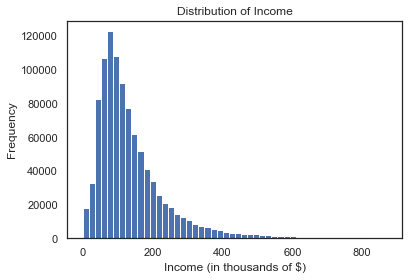

In [136]:
plt.hist(df.income.nsmallest(n=999900,keep='all'), bins=50)
plt.xlabel("Income (in thousands of $)")
plt.ylabel("Frequency")
plt.title("Distribution of Income")
plt.show()

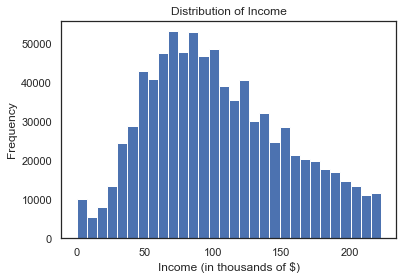

In [137]:
plt.hist(df.income.nsmallest(n=850000,keep='all'), bins=30)
plt.xlabel("Income (in thousands of $)")
plt.ylabel("Frequency")
plt.title("Distribution of Income")
plt.show()

In [ ]:
mean_income = np.around(np.mean(df.income),decimals=2)
median_income = np.around(np.median(df.income),decimals=2)

print("The mean income is: $"+str(mean_income*1000)+"/yr and the median income is: $"+str(median_income*1000)+"/yr")

This is a high average, even for CA, so I'm still questioning whether or not the data is accurate.

### debt_to_income_ratio

Description: The ratio, as a percentage, of the applicant’s or borrower’s total monthly debt to the total monthly income relied on in making the credit decision
Varying values; Ratios binned are:
- less than 20%
- 20%-<30%
- 30%-<36%
- 37%
- 38%
- 39%
- 40%
- 41%
- 42%
- 43%
- 44%
- 45%
- 46%
- 47%
- 48%
- 49%
- 50%-60%
- more than 60%
- NA
- Exempt

Here I will re-bin some of these so we have less categories.

In [ ]:
#Re-binning some of the DTI percentages to minimize how many categories we have here
df.loc[df['debt_to_income_ratio'] == '49', 'debt_to_income_ratio'] = '45%-<50%'
df.loc[df['debt_to_income_ratio'] == '48', 'debt_to_income_ratio'] = '45%-<50%'
df.loc[df['debt_to_income_ratio'] == '47', 'debt_to_income_ratio'] = '45%-<50%'
df.loc[df['debt_to_income_ratio'] == '46', 'debt_to_income_ratio'] = '45%-<50%'
df.loc[df['debt_to_income_ratio'] == '45', 'debt_to_income_ratio'] = '45%-<50%'

df.loc[df['debt_to_income_ratio'] == '40', 'debt_to_income_ratio'] = '40%-<45%'
df.loc[df['debt_to_income_ratio'] == '41', 'debt_to_income_ratio'] = '41%-<45%'
df.loc[df['debt_to_income_ratio'] == '42', 'debt_to_income_ratio'] = '42%-<45%'
df.loc[df['debt_to_income_ratio'] == '43', 'debt_to_income_ratio'] = '43%-<45%'
df.loc[df['debt_to_income_ratio'] == '44', 'debt_to_income_ratio'] = '44%-<45%'

df.loc[df['debt_to_income_ratio'] == '39', 'debt_to_income_ratio'] = '37%-<40%'
df.loc[df['debt_to_income_ratio'] == '38', 'debt_to_income_ratio'] = '37%-<40%'
df.loc[df['debt_to_income_ratio'] == '37', 'debt_to_income_ratio'] = '37%-<40%'
df.loc[df['debt_to_income_ratio'] == '36', 'debt_to_income_ratio'] = '37%-<40%'
df.loc[df['debt_to_income_ratio'] == '35', 'debt_to_income_ratio'] = '37%-<40%'





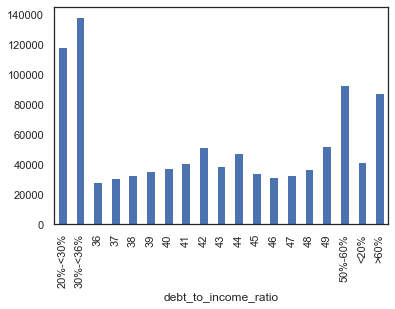

In [113]:
df.debt_to_income_ratio.value_counts()
df.groupby('debt_to_income_ratio').size().plot(kind='bar')

### TARGET : loan_type

In [114]:

df.loan_type.value_counts()

1    909416
2     99707
Name: loan_type, dtype: int64

# EDA

I'll start by just taking a look at some continuous-valued attributes to identify any patterns I see. Let's start with income vs. loan_amount:

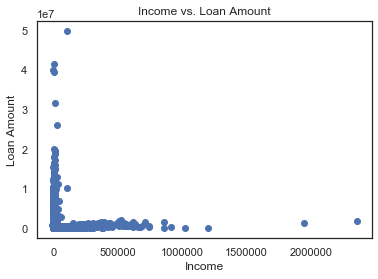

In [115]:
plt.scatter(df.income,df.loan_amount)
plt.xlabel("Income")
plt.ylabel("Loan Amount")
plt.title("Income vs. Loan Amount")

plt.show()

It looks like the visual is too zoomed out to see the patterns here, so I will section it off to really see what's going on. At first glance, it looks like there may be a few different trends in different portions of the plot.

##### I'm not sure exactly what these 2 branches are, and it's concerning me that some data wasn't entered with income in thousands...

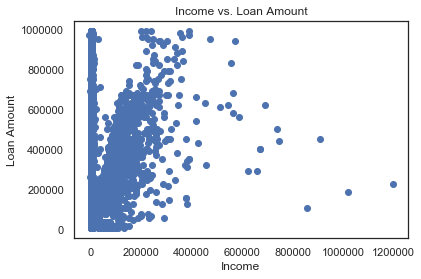

In [116]:
df_loan_cap_1M = df[df.loan_amount<1000000]
plt.scatter(df_loan_cap_1M.income,df_loan_cap_1M.loan_amount)
plt.xlabel("Income")
plt.ylabel("Loan Amount")
plt.title("Income vs. Loan Amount")
plt.show()

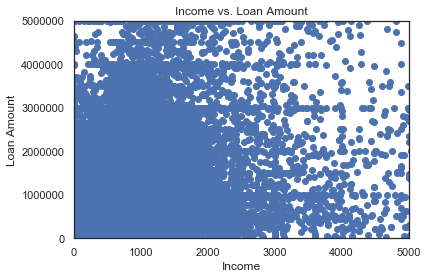

In [117]:
#Here we have loan_amount limit of $5,000,000 and income limit of $5,000,000
plt.scatter(df.income,df.loan_amount)
plt.xlabel("Income")
plt.ylabel("Loan Amount")
plt.title("Income vs. Loan Amount")
plt.xlim(0,5000)
plt.ylim(0,5000000)
plt.show()

In [118]:
#range of loan amounts
max_loan_amount = df.loan_amount.max()
min_loan_amount = df.loan_amount.min()
print(min_loan_amount, max_loan_amount)

5000.0 49905000.0


In [119]:
#income of the applicant for the highest loan amount
df.income[df.loc[df['loan_amount'] == df.loan_amount.max()].index]

567515    107909.0
Name: income, dtype: float64

In [120]:
#loan amount of the applicant with the highest income, supposedly $2B/year income...
#Why would they apply for a $1,775,000 loan 
df.loan_amount[df.loc[df['income'] == df.income.max()].index]

1328913    1775000.0
Name: loan_amount, dtype: float64

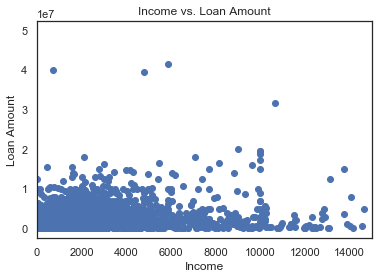

In [121]:
plt.scatter(df.income,df.loan_amount)
plt.xlabel("Income")
plt.ylabel("Loan Amount")
plt.title("Income vs. Loan Amount")
plt.xlim(0,15000)
#plt.ylim(0,5000000)
plt.show()

It looks like around 11M/year there is a cutoff where we see the second branch of the graph coming out. This is where I believe there is an issue with how the data was collected. There are only about 1600 entries above that, so I'm thinking it makes the most sense to get rid of these ones... Not sure if it will help the model at all, but it seems like it could.

##### if income were really in thousands, then the following graph would be loans for people with gross annual income of over 10,000,000/yr...


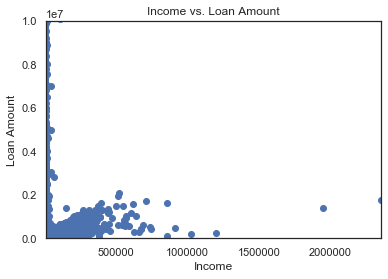

In [122]:
#Here we have loan_amount limit of $10,000,000 and only income above $10,000,000/yr all the way to $2.3 Billion/yr
plt.scatter(df.income,df.loan_amount)
plt.xlabel("Income")
plt.ylabel("Loan Amount")
plt.title("Income vs. Loan Amount")
plt.xlim(10000,income_max)
plt.ylim(0,10000000)
plt.show()

In [123]:
df.loc[df['income']>5000,'income'] = df['income']*.001

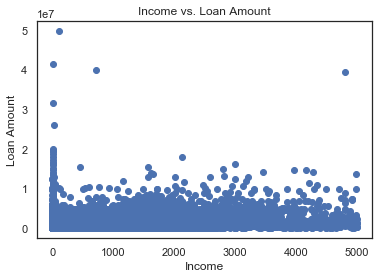

In [139]:
plt.scatter(df.income,df.loan_amount)
plt.xlabel("Income")
plt.ylabel("Loan Amount")
plt.title("Income vs. Loan Amount")

plt.show()

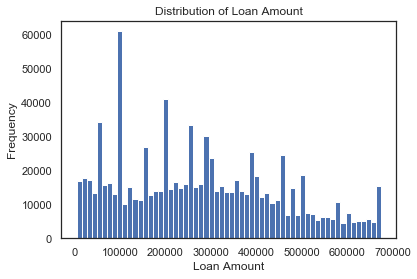

In [126]:
plt.hist(df.loan_amount.nsmallest(n=900000,keep='all'), bins=60)
plt.xlabel("Loan Amount")
plt.ylabel("Frequency")
plt.title("Distribution of Loan Amount")
plt.show()

I can see a trend here behind the loan amounts that are more common. Looks like mean is somewhere in the $300K range

In [127]:
mean_loan = np.around(np.mean(df.loan_amount),decimals=2)
median_loan = np.around(np.median(df.loan_amount),decimals=2)

print("The average loan_amount is: $"+str(mean_loan)+" and the median loan_amount is: $"+str(median_loan))

mean_income = np.around(np.mean(df.income),decimals=2)
median_income = np.around(np.median(df.income),decimals=2)

print("The mean income is: $"+str(mean_income*1000)+"/yr and the median income is: $"+str(median_income*1000)+"/yr")

The average loan_amount is: $366055.74 and the median loan_amount is: $285000.0
The mean income is: $153020.0/yr and the median income is: $110000.0/yr


In [128]:
transformed_df = pd.get_dummies(df)

In [129]:
def multi_collinearity_heatmap(df, figsize=(11,9)):
    
    """
    Creates a heatmap of correlations between features in the df. A figure size can optionally be set.
    """
    
    # Set the style of the visualization
    sns.set(style="white")

    # Create a covariance matrix
    corr = df.corr()

    # Generate a mask the size of our covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmax=corr[corr != 1.0].max().max());

In [130]:
#These showed higher collinearity (above 0.8) and also had little to no importance on the model, so I will now drop them
transformed_df.drop(['tract_median_age_of_housing_units','tract_owner_occupied_units',
                     'tract_one_to_four_family_homes', 'tract_population'],axis=1,inplace=True)
transformed_df.drop(['interest_only_payment','total_units_1','total_units_2','total_units_3','total_units_4','balloon_payment','preapproval'],axis=1,inplace=True)

In [71]:
transformed_df.drop(['tract_to_msa_income_percentage',
                     'tract_minority_population_percent'],axis=1,inplace=True)

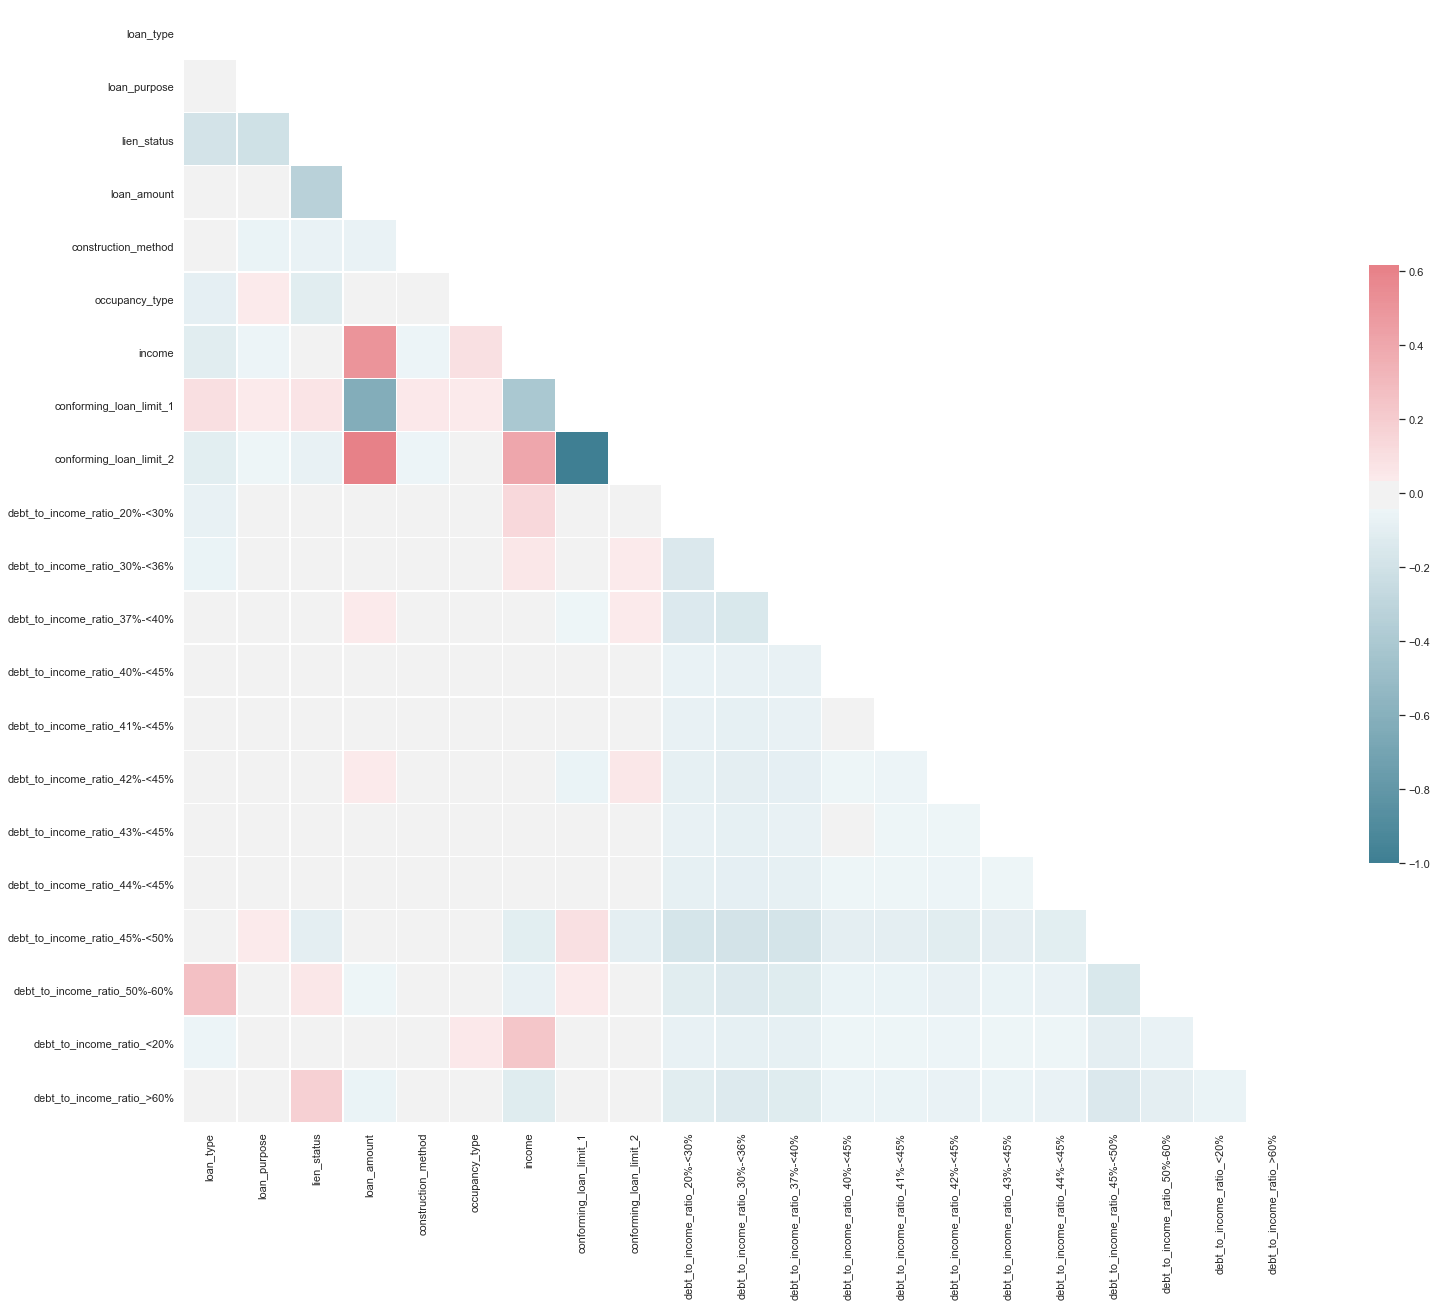

In [72]:
multi_collinearity_heatmap(transformed_df, figsize=(25,22))

In [73]:
# Separating X and y
X = transformed_df.drop('loan_type', axis=1)
y = transformed_df.loan_type

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [75]:
from sklearn.ensemble import RandomForestClassifier

rfr = RandomForestClassifier(n_estimators=500, max_depth=20)
#param_grid = [
  #{'max_depth': [5,15,20]}
#]
#grid_search = GridSearchCV(estimator=rfr, param_grid=param_grid, cv=3, verbose=-1)
#grid_search.fit(X_train, y_train)

rfr.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [76]:
train_rf_predictions = rfr.predict(X_train)
train_rf_probs = rfr.predict_proba(X_train)[:, 1]

rf_predictions = rfr.predict(X_test)
rf_probs = rfr.predict_proba(X_test)[:, 1]

In [77]:
def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    
    baseline['precision'] = precision_score(y_test, [1 for _ in range(len(y_test))])
    baseline['roc'] = 0.5
    
    results = {}
    
    
    results['precision'] = precision_score(y_test, predictions)
    results['roc'] = roc_auc_score(y_test, probs)
    
    train_results = {}
    
    train_results['precision'] = precision_score(y_train, train_predictions)
    train_results['roc'] = roc_auc_score(y_train, train_probs)
    
    for metric in ['precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))], pos_label=2)
    model_fpr, model_tpr, _ = roc_curve(y_test, probs, pos_label=2)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');

Precision Baseline: 0.9 Test: 0.93 Train: 0.93
Roc Baseline: 0.5 Test: 0.89 Train: 0.93


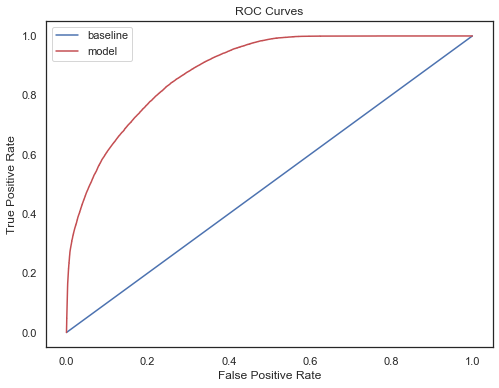

In [78]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)

In [79]:
pd.set_option('display.max_rows', None)
ft_weights_rfr = pd.DataFrame(rfr.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_rfr.sort_values('weight', inplace=True)
ft_weights_rfr

,weight
debt_to_income_ratio_40%-<45%,0.001263
debt_to_income_ratio_41%-<45%,0.001492
debt_to_income_ratio_42%-<45%,0.001638
debt_to_income_ratio_43%-<45%,0.001853
debt_to_income_ratio_44%-<45%,0.003293
debt_to_income_ratio_<20%,0.003391
debt_to_income_ratio_37%-<40%,0.003668
debt_to_income_ratio_30%-<36%,0.005793
debt_to_income_ratio_45%-<50%,0.006089
debt_to_income_ratio_>60%,0.008335


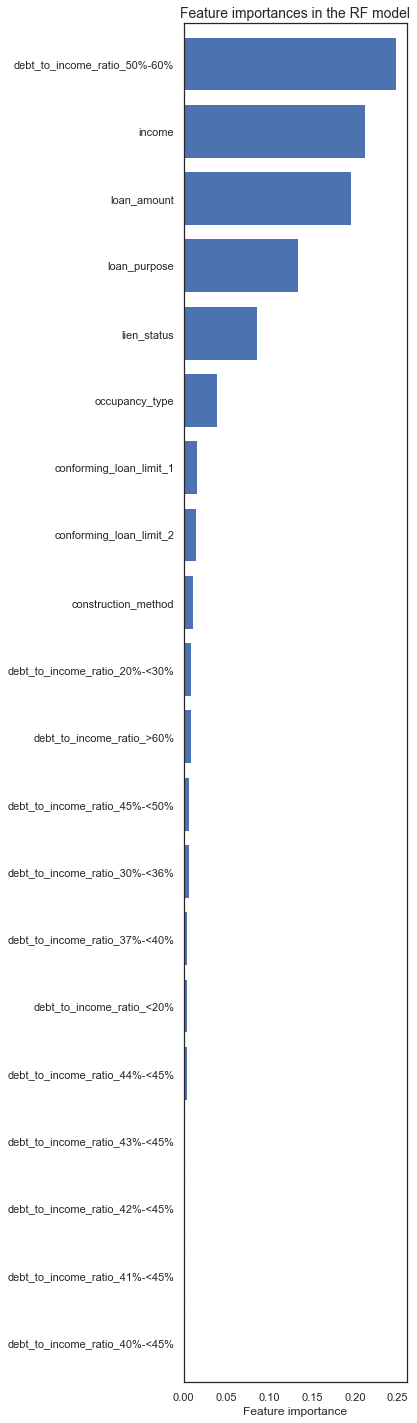

In [80]:
plt.figure(figsize=(4,25))
plt.barh(ft_weights_rfr.index, ft_weights_rfr.weight, align='center') 
plt.title("Feature importances in the RF model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

From looking at the importance of each feature, it looks like we could probably get rid of the total_units, balloon_payment, preapproval and interest_only_payment attributes with little or no consequence.